In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"] # number of products
N_x = Params["N_x"] # dimension of product features
c_l = Params["c_l"] 
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"] # dimension of customer features
S_train = Params["S_train"] # training data size
S_test = Params["S_test"] # test data size
N_Max = Params["N_Max"] # maximum assortment size
N_nonzero = Params["N_nonzero"] # number of nonzero entries in A
Time_Limit = Params["Time_Limit"] # time limit for optimization
dual_norm = Params["dual_norm"] # dual norm for robust optimization
gamma_list = Params["gamma_list"] # list of gamma values for robust optimization
psi_lb = Params["psi_lb"] # lower bound for psi
psi_ub = Params["psi_ub"] # upper bound for psi
phi_lb = Params["phi_lb"]   # lower bound for phi
phi_ub = Params["phi_ub"]  # upper bound for phi
num_c = Params["num_c"] # number of customer segments
instances = Params["instances"] # number of instances
seed = Params["seed"] # random seed
coef_this = Params["coef_this"] # coefficient for data generation
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"] # coefficient for Wang, Qi, Shen data generation

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = false;
is_same_util_para = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    coef_para_Input = coef_this;
    project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_para_Input);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design_ECP_Estimation/")
data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design_ECP_Estimation/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/


In [4]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

### Lambda = 0.0

In [5]:
is_ridge = false
lambda = 0.0
Input_Data = Dict()
RST_True_All = Dict()
RST_ETO_All = Dict()
RST_RO_All = Dict()
ins = 1
while ins <= instances
    if is_same_util_para
        Input_Data_this = Generate_Data_this_Same_Para(N_Max,N_x,N_u,S_train,S_test,theta_true_Fixed, r_params_Fixed);
    else
        Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
    end
    theta_true,r_params,X_train,Y_train,Z_train,Asorrtment_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this);
    Input_Data["ins=$(ins)"] = Input_Data_this
    nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
    nu_all_true = [nu0_true;nu_true]

    theta_Input = theta_true
    RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
    if status_True != "OPTIMAL"
        println("Warning: The true model did not reach optimality")
        continue
    end
    RST_True_All["ins=$(ins)"] = RST_True

    theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, Asorrtment_train,is_ridge, lambda)
    nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
    nu_all_hat = [nu0_hat;nu_hat]
    if any(isnan, nu_all_hat) || norm(vec(nu_all_true .- nu_all_hat),2) >= 10
        println("Estimate contains NaN values or is too far from true parameters.")
        continue
    end

    RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
    if status_ETO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    RST_ETO_All["ins=$(ins)"] = RST_ETO
    
    RST_RO_this = Dict()
    gamma = gamma_list[1]
    RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
    if status_RO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
        println("Warning: The RO profit is not equivalent to ETO profit")
        continue
    end
    RST_RO_this[string("gamma=",gamma)] = RST_RO

    for g_index in 2:length(gamma_list)
        gamma = gamma_list[g_index]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        RST_RO_this[string("gamma=",gamma)] = RST_RO
    end
    RST_RO_All["ins=$(ins)"] = RST_RO_this
    println("******* ins = ",ins,"*********")
    ins = ins + 1
end
save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

******* ins = 1*********
******* ins = 2*********
******* ins = 3*********
******* ins = 4*********
******* ins = 5*********
******* ins = 6*********
******* ins = 7*********
******* ins = 8*********
******* ins = 9*********
******* ins = 10*********
******* ins = 11*********
******* ins = 12*********
******* ins = 13*********
******* ins = 14*********
******* ins = 15*********
******* ins = 16*********
******* ins = 17*********
******* ins = 18*********
******* ins = 19*********
******* ins = 20*********
******* ins = 21*********
******* ins = 22*********
******* ins = 23*********
******* ins = 24*********
******* ins = 25*********
******* ins = 26*********
******* ins = 27*********
******* ins = 28*********
******* ins = 29*********
******* ins = 30*********
******* ins = 31*********
******* ins = 32*********
******* ins = 33*********
******* ins = 34*********
******* ins = 35*********
******* ins = 36*********
******* ins = 37*********
******* ins = 38*********
******* ins = 39*****

In [6]:
profit_True = zeros(instances);
profit_ETO = zeros(instances);
profit_RO = zeros(instances, length(gamma_list));
for ins in 1:instances
    profit_True[ins] = mean(RST_True_All["ins=$(ins)"]["profit"])
    profit_ETO[ins] = mean(RST_ETO_All["ins=$(ins)"]["profit"])
end
println("True profit: mean = ", mean(profit_True), ", std = ", std(profit_True))
println("ETO profit: mean = ", mean(profit_ETO), ", std = ", std(profit_ETO))
println("ETO/True Ratio = ", mean(profit_ETO)/mean(profit_True))

True profit: mean = 0.597865876925505, std = 0.0010021853878618317
ETO profit: mean = 0.49579226360406087, std = 0.07514724818650363
ETO/True Ratio = 0.8292700465757429


- Results

In [7]:
# lambda = 0.0
# Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
# RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [8]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0]


In [9]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:0.5979
profit ETO:0.4958
profit RO:[0.4958 0.4988 0.5043 0.5149 0.5217 0.5251 0.5272 0.5263 0.5223 0.5155]


- Line plot 

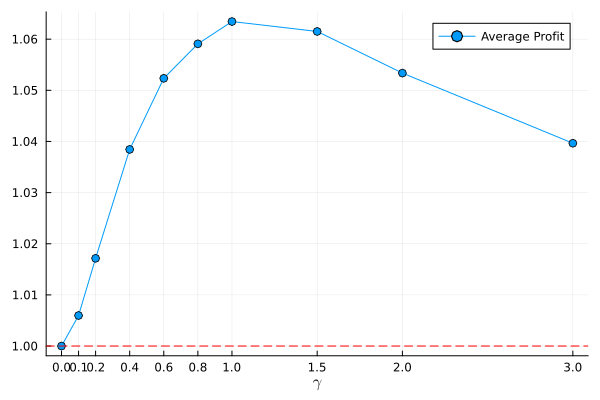

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design_ECP_Estimation/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [10]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

- Boxplot

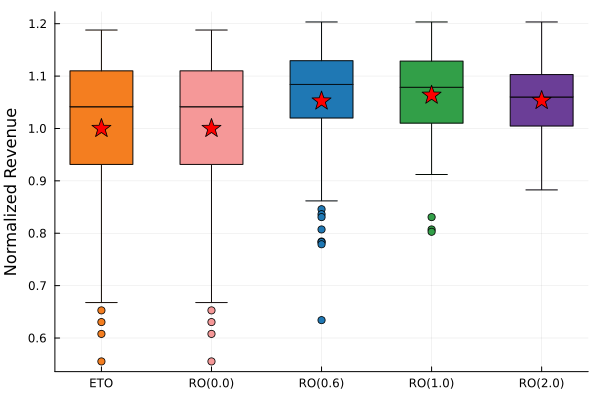

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design_ECP_Estimation/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/Boxplot_RPLD_vs_ETOPLD_lambda=0.0_Normalize.pdf"

In [11]:
Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO)
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
end

chosen_indices = [1,5,7,9]
gamma_chosen = gamma_list[chosen_indices]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$(lambda)_Normalize.pdf")
boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)

In [12]:
# gamma_index = length(gamma_list)
# fig_name = string(data_dir, "RPLD_vs_ETOPLD_Distribution_lambda=$(lambda)_gamma=$(gamma_list[gamma_index]).pdf")
# hist_profit_distribution(profit_ETO, profit_RO, gamma_index,gamma_list,fig_name)

# Lambda = 0.00001

In [13]:
# is_ridge = true
# lambda = 0.00001
# Input_Data = Dict()
# RST_True_All = Dict()
# RST_ETO_All = Dict()
# RST_RO_All = Dict()
# ins = 1
# while ins <= instances
#     if is_same_util_para
#         Input_Data_this = Generate_Data_this_Same_Para(N_Max,N_x,N_u,S_train,S_test,theta_true_Fixed, r_params_Fixed);
#     else
#         Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
#     end
#     theta_true,r_params,X_train,Y_train,Z_train,Asorrtment_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this);
#     Input_Data["ins=$(ins)"] = Input_Data_this
#     nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
#     nu_all_true = [nu0_true;nu_true]

#     theta_Input = theta_true
#     RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
#     # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
#     if status_True != "OPTIMAL"
#         println("Warning: The true model did not reach optimality")
#         continue
#     end
#     RST_True_All["ins=$(ins)"] = RST_True

#     theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, Asorrtment_train,is_ridge, lambda)
#     nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
#     nu_all_hat = [nu0_hat;nu_hat]
#     if any(isnan, nu_all_hat) || norm(vec(nu_all_true .- nu_all_hat),2) >= 10
#         println("Estimate contains NaN values or is too far from true parameters.")
#         continue
#     end

#     RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
#     # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
#     if status_ETO != "OPTIMAL"
#         println("Warning: The ETO model did not reach optimality")
#         continue
#     end
#     RST_ETO_All["ins=$(ins)"] = RST_ETO
    
#     RST_RO_this = Dict()
#     gamma = gamma_list[1]
#     RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
#     # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
#     if status_RO != "OPTIMAL"
#         println("Warning: The ETO model did not reach optimality")
#         continue
#     end
#     if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
#         println("Warning: The RO profit is not equivalent to ETO profit")
#         continue
#     end
#     RST_RO_this[string("gamma=",gamma)] = RST_RO

#     for g_index in 2:length(gamma_list)
#         gamma = gamma_list[g_index]
#         RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
#         # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
#         RST_RO_this[string("gamma=",gamma)] = RST_RO
#     end
#     RST_RO_All["ins=$(ins)"] = RST_RO_this
#     println("******* ins = ",ins,"*********")
#     ins = ins + 1
# end
# save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
# save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
# save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
# save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

In [14]:
# lambda = 0.00001
# Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
# RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [15]:
# profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("profit True:",round.(mean(profit_True),digits=4))
# println("profit ETO:",round.(mean(profit_ETO),digits=4))
# println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

In [16]:
# fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
# include_std = false
# line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

In [17]:
# Profit_ETO_All_Ins = profit_ETO
# Profit_RO_All_Ins = Dict();
# for g_index in 1:length(gamma_list)
#     gamma=gamma_list[g_index]
#     Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]
# end

# chosen_indices = [1,5,7,9]
# gamma_chosen = gamma_list[chosen_indices]
# data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$lambda.pdf")
# boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)

In [18]:
# gamma_index = length(gamma_list)
# fig_name = string(data_dir, "RPLD_vs_ETOPLD_Distribution_lambda=$(lambda)_gamma=$(gamma_list[gamma_index]).pdf")
# hist_profit_distribution(profit_ETO, profit_RO, gamma_index,gamma_list,fig_name)

#### Wang_Qi_Max

In [19]:
# lambda = 0.01

# Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_Wang_Qi_Shen)
# theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)

# theta_Input = theta_true
# RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

# theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
# RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

In [20]:
# nu0_true, nu_true = compute_w(theta_true,Z_test[1,:])
# nu0_hat, nu_hat = compute_w(theta_hat,Z_test[1,:])
# println("W true = ", round.([nu0_true; nu_true],digits=4))
# println("W hat  = ", round.([nu0_hat; nu_hat],digits=4))

In [21]:
# println("Price coef = ",round.(r_params.r,digits=4))

In [22]:
# RST_True["X"][1,:,:]

In [23]:
# RST_ETO["X"][1,:,:]

In [24]:
# price_true = RST_True["X"][1,:,:] * r_params.r
# price_eto = RST_ETO["X"][1,:,:] * r_params.r
# println("True Price = ", round.(price_true,digits=4))
# println("ETO  Price = ", round.(price_eto,digits=4))

In [25]:
# util_true = nu0_true .+ RST_True["X"][1,:,:] * nu_true;
# exp_util_true = exp.(util_true);
# prob_util_true = exp_util_true ./ (1+sum(exp_util_true))

In [26]:
# util_hat = nu0_hat .+ RST_ETO["X"][1,:,:] * nu_hat;
# exp_util_hat = exp.(util_hat);
# prob_util_hat = exp_util_hat ./ (1+sum(exp_util_hat))

In [27]:
# println("True rev = ",prob_util_true' * price_true)
# println("True rev = ",prob_util_hat' * price_eto)